# Setup

In [1]:
!conda upgrade scikit-learn -y

/bin/sh: conda: command not found


In [2]:
from azureml import Workspace

import warnings
warnings.filterwarnings('ignore')

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
#from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import requests
import json

from pylab import rcParams
rcParams['figure.figsize'] = 14, 3
%matplotlib inline
pd.options.display.max_colwidth = 500

In [3]:
ws = Workspace()

# Pull in and Pre-Process Data

**Import data**

In [4]:
vel_raw = ws.datasets['channel-5607-10008.csv'].to_dataframe().set_index('time').value
vel_edited = ws.datasets['channel-5607-9894.csv'].to_dataframe().set_index('time').value

df = pd.concat({'velocity': vel_raw, 'velocity_edited': vel_edited}, axis=1, join='inner')
df = df.reset_index()
df['time'] =  pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M')
df = df.set_index('time')

**Generate Velocity N window size of 4**

In [5]:
#create level channels
for i in range(1, 5):
    df['velocity_{}'.format(i)] = df.velocity.shift(i)
df = df.dropna()  

**Tag Anomolies**

In [6]:
df['diff'] = np.abs(df.velocity - df.velocity_edited)
df['anomaly'] = df['diff'].apply(lambda x: 1 if x > 0 else 0)

# Visualize Data

**Check Few Points**

In [7]:
df['2013-04-02 02:30:00':'2013-04-02 02:50:00']

,velocity,velocity_edited,velocity_1,velocity_2,velocity_3,velocity_4,diff,anomaly
time,,,,,,,,
2013-04-02 02:30:00,0.345,0.345000,0.641,0.961,0.930,0.968,0.000000,0
2013-04-02 02:35:00,0.328,0.328000,0.345,0.641,0.961,0.930,0.000000,0
2013-04-02 02:40:00,0.000,0.289756,0.328,0.345,0.641,0.961,0.289756,1
2013-04-02 02:45:00,0.266,0.266000,0.000,0.328,0.345,0.641,0.000000,0
2013-04-02 02:50:00,0.974,0.974000,0.266,0.000,0.328,0.345,0.000000,0


**Plot Sample Daily Pattern**

/home/nbuser/anaconda2_20/lib/python2.7/site-packages/dateutil/rrule.py:450: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)


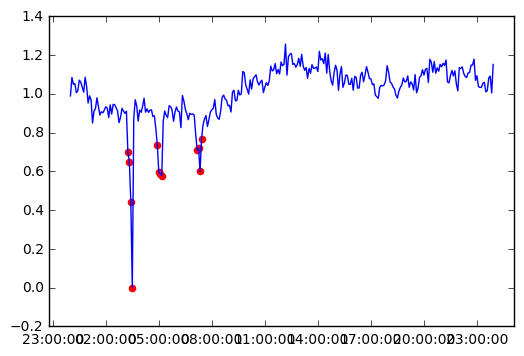

In [8]:
day_df = df['2013-09-02':'2013-09-02']
day_anomalies = day_df[day_df['anomaly']==1]
plt.plot(day_df['velocity'])
plt.scatter(day_anomalies.index, day_anomalies.velocity, color='r')

# Compare Anomaly Detection and Outlier Detection Models

**Define Metrics**

In [9]:
def print_report(expected, predicted):
    target_names = ['Anomalies', 'Regular velocity']
    print("Confusion Matrix")
    print(confusion_matrix(expected, predicted)) 
    print(classification_report(expected, predicted, target_names = target_names))

**Model #1 : Outlier Detection**

- Read in channels
- Tag anomalies at last point using the difference between the raw and curated channel 
- Score outlier model using anomaly detection api on raw channel

In [23]:
#Define Key 
key = 'Put anomaly detection key here' #https://azure.microsoft.com/en-us/marketplace/partners/aml-labs/anomalydetection/

In [11]:
#Format data for processing 
velDf = vel_raw.to_frame().reset_index()
velDf.value = velDf.value.astype(str)
values = velDf.values.tolist()

#Score anomolies
url = 'https://api.datamarket.azure.com/data.ashx/aml_labs/anomalydetection/v2/Score'
payload = { "data": values, "params": { "tspikedetector.sensitivity": "1",
                                        "zspikedetector.sensitivity": "1", 
                                        "trenddetector.sensitivity": "1", 
                                        "bileveldetector.sensitivity": "1"
                                      } 
          }
headers = {'content-type': 'application/json'}
req = requests.post(url, data=json.dumps(payload), headers=headers, auth = ('AccountKey',key))

res = json.loads(req.json()['ADOutput'])
outliers = pd.DataFrame(res['Values'], columns=res['ColumnNames'])


In [14]:
outliers['detected_outliers'] = pd.to_numeric(outliers['rpscore']).apply(lambda x: 1 if x > 0 else 0)
print_report(df['anomaly'], outliers[4:]['detected_outliers'])

Confusion Matrix
[[52323   442]
 [  437    58]]
                  precision    recall  f1-score   support

       Anomalies       0.99      0.99      0.99     52765
Regular velocity       0.12      0.12      0.12       495

     avg / total       0.98      0.98      0.98     53260



The results here show that why the outlier detection algorithm identitifes 500 outliers and 58 anomolies it misses other anomlies.

**Model #2: Binary Classifier**

- Read in channels 
- Tag anomalies at last point using the difference between the raw and curated channel using the [Anomaly Detection API](https://docs.microsoft.com/en-gb/azure/machine-learning/machine-learning-apps-anomaly-detection)
- For classification take an n-size window of channel values mark the output as an anomaly 



In [21]:
#Define test and training set
columns = ['velocity', 'velocity_1','velocity_2','velocity_3','velocity_4']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(df[columns], df.anomaly, test_size=0.3)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
xs = clf.predict(X_test)
print_report(y_test, xs)

Confusion Matrix
[[15815     4]
 [   43   116]]
                  precision    recall  f1-score   support

       Anomalies       1.00      1.00      1.00     15819
Regular velocity       0.97      0.73      0.83       159

     avg / total       1.00      1.00      1.00     15978



**Model #3: Hybrid Classifier**

- Apply classification model from step 2 to results from step 1

In [22]:
detected_outliers = pd.DataFrame({'time':outliers[4:]['Time'],'detected_outliers':outliers[4:]['detected_outliers']})
detected_outliers = detected_outliers[detected_outliers['detected_outliers'] == 1]
detected_outliers['time'] = pd.to_datetime(detected_outliers['time'])
df_outliers = df.loc[detected_outliers['time']]
oseries = clf.predict(df_outliers[columns])
print_report(df_outliers.anomaly, oseries)

Confusion Matrix
[[442   0]
 [  1  57]]
                  precision    recall  f1-score   support

       Anomalies       1.00      1.00      1.00       442
Regular velocity       1.00      0.98      0.99        58

     avg / total       1.00      1.00      1.00       500



The binary classification model was able to greatly help differentiate between the outliers, anomolies and regular values. While in this data set the anomolies are lineraly seperable in others this technique could be used to yield more accurate results.

## Results

Though the anomoly detection API helped differentiate indetitify outliers for anomoly classification, in Carl Data's dataset the difference between anomalies and regular flow was linearly differentiable enough that a random forrest binary classifier was able to provide just as good results as the anomoly detection API without the overhead. 

